## Imports

In [2]:

# RegEx and String Manipulation
import re
import string

# Language Detection
from nltk.classify.textcat import TextCat

# Multiprocessing
import dask.dataframe as dd
import multiprocessing

# BERT-Embeddings
from keybert import KeyBERT

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Plotting Heatmap of TF-IDF vectors
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('mimetype')

# Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarityfrom IPython.display import Image,display

import os
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%%time
book_rating = pd.read_csv("/content/drive/MyDrive/Datasets/Goodreads/book2000k-3000k.csv")



CPU times: user 3.91 s, sys: 395 ms, total: 4.3 s
Wall time: 4.45 s


In [13]:
book_rating.Language.value_counts()

eng      27871
fre       4662
ger       2919
en-US     2468
spa       1628
         ...  
ypk          1
epo          1
cop          1
hin          1
lit          1
Name: Language, Length: 73, dtype: int64

In [15]:
book_rating = book_rating[(book_rating["Language"] == "eng") | (book_rating["Language"] == "en-US")]


In [16]:
book_rating.shape

(30339, 19)

In [17]:
book_rating.head()

,Id,Name,Authors,ISBN,Rating,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,RatingDist4,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,PagesNumber,Description
11,2000045,Strategic Operations Management,Steve Brown,0750663197,4.00,2005,1,1,Butterworth-Heinemann,5:2,4:4,3:2,2:0,1:0,total:8,0,eng,420,Only when managers understand their operations...
67,2000294,"Bastard!!, Vol. 16",Kazushi Hagiwara,1421508796,3.86,2008,1,8,VIZ Media LLC,5:13,4:12,3:7,2:4,1:1,total:37,3,eng,184,While Dark Schneider's in hell chatting with S...
79,2000333,Daily Readings with Jean-Pierre de Caussade,Jean-Pierre de Caussade,0872431452,4.50,1992,2,1,Templegate Publishers,5:1,4:1,3:0,2:0,1:0,total:2,1,eng,96,NaN
88,2000356,Visible Bones: Journeys Across Time in the Col...,Jack Nisbet,1570615241,3.85,2007,4,10,Sasquatch Books,5:13,4:24,3:13,2:4,1:0,total:54,5,eng,256,How can you know a place? Historian and natura...
110,2000413,"Mouryou Kiden: Legend of the Nymph, Vol. 03",Tamayo Akiyama,1595322477,2.83,2005,6,7,Tokyopop,5:3,4:3,3:7,2:9,1:2,total:24,1,eng,208,"When Ayaka finds Kai, everything is not as it ..."


In [73]:
# Only keep columns we need
eda_data = book_rating[['Id', 'Name', 'Authors', 'ISBN', 'PublishYear', 'Publisher', 'Language', 'Description']].copy()
eda_data.head()

,Id,Name,Authors,ISBN,PublishYear,Publisher,Language,Description
0,2427424,Raising Standards or Raising Barriers?: Inequa...,Gary Orfield,087078451X,2001,Century Foundation Press,NaN,More and more states require students to pass ...
1,2635062,The Scarlet Letter: A Romance,Nathaniel Hawthorne,0140862072,1995,Penguin Audiobooks,NaN,"A story of love, guilt, sin and redemption pla..."
2,2758867,Taking Glasnost Seriously: Toward an Open Sovi...,Michael Novak,0844736422,1988,AEI Press,eng,This book examines the Soviet Union and the gr...
3,2252829,Caliphate,Tom Kratman,1416555455,2008,Baen,NaN,Demography is destiny. In the 22nd century Eur...
4,2199595,Ali Baba: Fooling the Forty Thieves: An Arabia...,Marie P. Croall,0822575256,2008,Graphic Universe,NaN,This graphic novel tells a classic tale from A...


In [74]:
!pip install keybert altair

In [9]:
# Minimum number of words that should be present in a description (value starting from 1)
min_description_word_count = 3

In [76]:
book_rating.columns

Index(['Id', 'Name', 'Authors', 'ISBN', 'Rating', 'PublishYear',
       'PublishMonth', 'PublishDay', 'Publisher', 'RatingDist5', 'RatingDist4',
       'RatingDist3', 'RatingDist2', 'RatingDist1', 'RatingDistTotal',
       'CountsOfReview', 'Language', 'PagesNumber', 'Description'],
      dtype='object')

In [77]:
books_data = book_rating[['Id', 'Name', 'Authors', 'ISBN', 'PublishYear', 'Publisher', 'Language', 'Description']].copy(deep=True)
display(books_data.shape)
books_data.head(5)

(10000, 8)

,Id,Name,Authors,ISBN,PublishYear,Publisher,Language,Description
0,2427424,Raising Standards or Raising Barriers?: Inequa...,Gary Orfield,087078451X,2001,Century Foundation Press,NaN,More and more states require students to pass ...
1,2635062,The Scarlet Letter: A Romance,Nathaniel Hawthorne,0140862072,1995,Penguin Audiobooks,NaN,"A story of love, guilt, sin and redemption pla..."
2,2758867,Taking Glasnost Seriously: Toward an Open Sovi...,Michael Novak,0844736422,1988,AEI Press,eng,This book examines the Soviet Union and the gr...
3,2252829,Caliphate,Tom Kratman,1416555455,2008,Baen,NaN,Demography is destiny. In the 22nd century Eur...
4,2199595,Ali Baba: Fooling the Forty Thieves: An Arabia...,Marie P. Croall,0822575256,2008,Graphic Universe,NaN,This graphic novel tells a classic tale from A...


In [65]:
books_data.isnull().sum()

Id                0
Name              0
Authors           0
ISBN             36
PublishYear       0
Publisher       103
Language       8928
Description    2112
dtype: int64

In [58]:
books_data.dropna(subset=["Description"], inplace=True)

In [61]:
books_data.isnull().sum()

Id                0
Name              0
Authors           0
ISBN             23
PublishYear       0
Publisher        62
Language       6984
Description       0
dtype: int64

In [79]:
def add_nan(x):
  x = str(x)
  if x == "": x = "nan"
  return x

In [80]:
books_data['Description'] = books_data["Description"].apply(add_nan)

In [81]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
def remove_url(text):
    return re.sub(url_pattern, r'', text)

html_pattern = re.compile('<[^>]*>')
def clean_html_tags(text):
    return re.sub(html_pattern, r'', text)

punctuations = string.punctuation
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', punctuations))

books_data.Description = books_data.Description.apply(remove_url)
books_data.Description = books_data.Description.apply(clean_html_tags)
books_data.Description = books_data.Description.apply(remove_punctuations)


[]

In [82]:
books_data[["Publisher"]] = books_data[["Publisher"]].fillna("unknown")
books_data[["Name", "Authors", "Publisher", "Description"]] = pd.concat([books_data[col].astype(str).str.lower().str.strip()
                                                                             for col in ["Name", "Authors", "Publisher", "Description"]],
                                                                            axis=1)

In [83]:
# Find description word count
books_data["length"] = [len(d.split()) for d in books_data['Description'].tolist()]

print(set(books_data.Description[books_data.length.isin(range(0,4))]))

{'', '懺罪宮に幽閉されるルキアの元にたどり着いた岩鷲と花太郎。だが、それを察知した朽木白哉が二人の前に現れた！！\u3000白哉は、対峙する岩鷲に無慈悲な斬魄刀の一撃を放つ！\u3000万事休す…とその時、天空に一護の姿が！！', '「自分が死んでも、水野理瀬が半年以上ここに住まない限り家は処分してはならない」亡き祖母の奇妙な遺言に従い、「魔女の館」と噂される洋館に、理瀬は、やってきた………。', 'no', '太宰治が短篇の名手であることはひろく知られているが、ここに収めた作品は、いずれも様々な題材を、それぞれ素材に適わしい手法で描いていて、その手腕の確かさを今更のように思い起こさせる。表題作の他、『東京八景』『女生徒』『きりぎりす』『駈込み訴え』『魚服記』『ロマネスク』『満願』『八十八夜』を収録。 解説 井伏鱒二', '国民的辞典、10年ぶりの大改訂。充実の最新版、満を持して登場国民的な国語百科辞典の最新版。第六版を全面的に見直して、学術研究の進展や社会の変化に対応。新たに1万項目を増補し、既存項目にも新しく定着した意味を加える。基礎語の語釈や古典用例の見直しにも重点をおき、特に類義語の意味の違いをいっそう分かりやすくした。漢字小字典などを収めた便利な別冊付録つき。', 'language spanish', 'ampltbr ampgt ampgt', 'nan', 'for children', '桜咲く４月。希望に胸を膨らませた登校途中の少女が、桜並木で出会ったのは、新クラスの担任の先生だった‥‥。そこまでは良い話。その先生の名は糸色望。学校から飛び下りたり、すぐ不登校になったり、超迷惑なネガティブ教師だった！通称「絶望先生」が引っかき回すクラスでは、予想不能な事件が毎回毎回起きるのです！', '学園生活の中で、誰もが一つや二つ抱えてしまう悩みや問題。それらを何でも解決してくれる、学園生活の助っ人になってくれるヤツらがいた！\u3000彼ら学園生活支援部――通称“スケット団”に、今日も仕事の依頼が舞い込む！！', '無敵の禁断カップル・夜斗と緋佐子。熱愛同棲中の二人は、今宵も甘い欲望にトロけるのであった…ある日、骨董店オーナーの祖父が緋佐子たちのもとを訪れた。彼は緋佐子のことが大のお気に入り！！彼女のために、商店街の新年会で夜斗も驚きの（？）演出をし

In [84]:
# Replace empty strings of description with NaN
books_data.Description = books_data.Description.replace(r'^\s*$', np.nan, regex=True)

books_data[books_data.length.isin(range(1,min_description_word_count+1))][["Id", "Name", "Description", "length"]]\
.sort_values(by=["length"], ascending=True).head(5)

,Id,Name,Description,length
11,2177645,"1881 census returns, lanark township, lanark c...",nan,1
6576,2440684,financial markets for the rest of us: an easy ...,nan,1
6571,2931292,incidents at whiterock: and other stories,nan,1
6560,2254119,tennessee civil procedure,nan,1
6559,2221629,life of the amir dost mohammed khan of kabul,nan,1


In [85]:
books_data.head()

,Id,Name,Authors,ISBN,PublishYear,Publisher,Language,Description,length
0,2427424,raising standards or raising barriers?: inequa...,gary orfield,087078451X,2001,century foundation press,NaN,more and more states require students to pass ...,66
1,2635062,the scarlet letter: a romance,nathaniel hawthorne,0140862072,1995,penguin audiobooks,NaN,a story of love guilt sin and redemption playe...,18
2,2758867,taking glasnost seriously: toward an open sovi...,michael novak,0844736422,1988,aei press,eng,this book examines the soviet union and the gr...,17
3,2252829,caliphate,tom kratman,1416555455,2008,baen,NaN,demography is destiny in the 22nd century euro...,171
4,2199595,ali baba: fooling the forty thieves: an arabia...,marie p. croall,0822575256,2008,graphic universe,NaN,this graphic novel tells a classic tale from a...,95


In [86]:
# Convert unknown to NaN
books_data["Publisher"] = books_data.Publisher.replace('unknown',np.nan)
books_data["Description"] = books_data.Description.replace('nan',np.nan)
books_data = books_data.sort_values(by="Publisher", na_position='last')\
.drop_duplicates(subset=["Name", "Authors", "Description"], keep='first')

In [87]:
series_pattern =  "(?:[;]\s*|\(\s*)([^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*))"
def get_book_series_info(text):
    series_info = re.findall(series_pattern, text)
    if series_info:
        series_info = " ".join([i.replace(" ", "_") for i in series_info])
        return series_info
    else:
        return np.nan

books_data['BookSeriesInfo'] = books_data.Name.apply(get_book_series_info)

In [88]:
series_remove_pattern = re.compile("(?:[\(]\s*[^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*)(?:;|\))|\s*[^\(;]*\s*#\s*\d+(?:\.?\d+|\\&\d+|-?\d*)\))")
def remove_series_info(text):
    return re.sub(series_remove_pattern, r'', text)

books_data["Title"]= books_data["Name"].str.replace(series_remove_pattern, r'').str.strip()

In [89]:
import nltk
nltk.download('crubadan')
nltk.download('punkt')

[nltk_data] Downloading package crubadan to /root/nltk_data...
[nltk_data]   Package crubadan is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [90]:
#Remove Double Quotes from Publisher Name

books_data["Publisher"] = books_data["Publisher"].str.replace('"','')

In [91]:
#Transform Book and Author Names into Single Token

books_data["Authors"] = books_data["Authors"].str.strip().str.replace(' ','_')
books_data["Publisher"] = books_data["Publisher"].str.strip().str.replace(' ','_')
books_data.head(5)

,Id,Name,Authors,ISBN,PublishYear,Publisher,Language,Description,length,BookSeriesInfo,Title
5679,2312681,the it's just lunch guide to dating in san die...,cathy_a._loe,1933174323,2010,10_finger_press,NaN,want to make good dates great mediocre dates m...,156,NaN,the it's just lunch guide to dating in san die...
9720,2094452,faux frère,paul_doherty,2264024399,1998,10/18,fre,le polar moyenâgeux est décidément à la mode s...,104,NaN,faux frère
9726,2934265,un deuil dangereux,anne_perry,226403307X,2001,10/18,fre,décembre 1856 à londres william monk et son éq...,156,NaN,un deuil dangereux
2716,2882410,prevention from the inside-out,jack_pransky,1410703754,2003,1st_book_library,NaN,NaN,1,NaN,prevention from the inside-out
5709,2792583,symphonic paradox: the misadventures of a wayw...,sam_denov,0759675430,2002,1st_book_library,NaN,sam denov recounts his fascinating adventures ...,35,NaN,symphonic paradox: the misadventures of a wayw...


In [92]:
#Merge All the Textual Summary into a Single Summary Column

books_data["bow"] = books_data[["BookSeriesInfo", 'Authors', 'Publisher', 'Language']].fillna('').agg(' '.join, axis=1)
books_data.bow.iloc[83]

' laszlo_fuchs academic_press '

In [93]:
# Save cleaned data
books_data.to_csv("/content/drive/MyDrive/Datasets/Goodreads/preprocessed.csv", sep=",", index=False)

In [95]:
fe_data = pd.read_csv("/content/drive/MyDrive/Datasets/Goodreads/preprocessed.csv", usecols=["Id", "Name", "Description", "bow"])
fe_data.head()

,Id,Name,Description,bow
0,2312681,the it's just lunch guide to dating in san die...,want to make good dates great mediocre dates m...,cathy_a._loe 10_finger_press
1,2094452,faux frère,le polar moyenâgeux est décidément à la mode s...,paul_doherty 10/18 fre
2,2934265,un deuil dangereux,décembre 1856 à londres william monk et son éq...,anne_perry 10/18 fre
3,2882410,prevention from the inside-out,NaN,jack_pransky 1st_book_library
4,2792583,symphonic paradox: the misadventures of a wayw...,sam denov recounts his fascinating adventures ...,sam_denov 1st_book_library


In [96]:
fe_data["Description"] = fe_data["Description"].astype(str)

In [97]:
fe_data

,Id,Name,Description,bow
0,2312681,the it's just lunch guide to dating in san die...,want to make good dates great mediocre dates m...,cathy_a._loe 10_finger_press
1,2094452,faux frère,le polar moyenâgeux est décidément à la mode s...,paul_doherty 10/18 fre
2,2934265,un deuil dangereux,décembre 1856 à londres william monk et son éq...,anne_perry 10/18 fre
3,2882410,prevention from the inside-out,nan,jack_pransky 1st_book_library
4,2792583,symphonic paradox: the misadventures of a wayw...,sam denov recounts his fascinating adventures ...,sam_denov 1st_book_library
...,...,...,...,...
9995,2489508,gymboree baby play,nan,wendy_s._masi
9996,2679310,the hadra,this third book in diana riverss critically ac...,diana_rivers eng
9997,2145700,winnie pooh tesoros para llevar (disney winnie...,nan,arlette_de_alba
9998,2000878,concepts of modern art revised and enlarge (wo...,the main concepts and development of art from ...,nikos_stangos


In [98]:
kw_model = KeyBERT()

def get_keywords(text):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words="english")
    keywords = " ".join([k[0] for k in keywords])
    return keywords

fe_data["keywords"] = fe_data.Description.apply(get_keywords)

In [99]:
fe_data.keywords.head()

0        dates dating datingplus date datefind
1     doherty corbette corbett polar enquêteur
2        monk basil poignardée inspecteur chef
3                                          nan
4    denov orchestras music musician classical
Name: keywords, dtype: object

In [100]:
fe_data["keywords"] = fe_data[['bow', 'keywords']].fillna('').agg(' '.join, axis=1)
fe_data.drop(['bow', 'Description'], axis = 1, inplace=True)

In [101]:
fe_data = fe_data.drop_duplicates(subset=["Name"], keep='first')

In [102]:
fe_data.to_csv("/content/drive/MyDrive/Datasets/Goodreads/features.csv", sep=",", index=False)


In [103]:
model_data = pd.read_csv("/content/drive/MyDrive/Datasets/Goodreads/features.csv")
model_data.head()

,Id,Name,keywords
0,2312681,the it's just lunch guide to dating in san die...,cathy_a._loe 10_finger_press dates dating da...
1,2094452,faux frère,paul_doherty 10/18 fre doherty corbette corbe...
2,2934265,un deuil dangereux,anne_perry 10/18 fre monk basil poignardée in...
3,2882410,prevention from the inside-out,jack_pransky 1st_book_library nan
4,2792583,symphonic paradox: the misadventures of a wayw...,sam_denov 1st_book_library denov orchestras ...


In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word',
                        min_df=3,
                        max_df = 0.6,
                        stop_words="english",
                        encoding = 'utf-8',
                        token_pattern=r"(?u)\S\S+")
tfidf_encoding = tfidf.fit_transform(fe_data["keywords"])

In [105]:
# Preview first 100 words in the vocabulary
print(tfidf.get_feature_names_out()[1:100])

['1800s' '1814' '1830' '1850' '1880' '1900s' '1912' '1914' '1916' '1918'
 '1920' '1920s' '1930s' '1935' '1940' '1940s' '1942' '1944' '1945' '1960s'
 '1996' '1997' '1999' '1st_book_library' '2001' '2004' '3d' '911'
 'a.a._milne' 'abbeville_press' 'abby' 'abc-clio' 'abdo_&_daughters'
 'abducted' 'abigail' 'abilities' 'abingdon_press'
 'ablex_publishing_corporation' 'aboriginal' 'abortion' 'abraham' 'abrams'
 'abuse' 'academic' 'academic_press' 'academics' 'acc_distribution'
 'access' 'acclaimed' 'accountability' 'accounting' 'ace' 'achieve'
 'achievement' 'act' 'actes_sud' 'acting' 'action' 'activism' 'activist'
 'activities' 'activity' 'actor' 'actors' 'actress' 'acts' 'acupuncture'
 'adam' 'adamant_media_corporation' 'adams' 'adams_media' 'addiction'
 'addison-wesley_professional' 'addison_wesley_longman'
 'addison_wesley_publishing_company' 'administration' 'administrators'
 'admission' 'admissions' 'adobe' 'adolescence' 'adolescent' 'adolescents'
 'adolf' 'adopted' 'adoption' 'adulth

In [106]:
tfidf_df = pd.DataFrame(tfidf_encoding.toarray(), index=model_data["Name"], columns=tfidf.get_feature_names_out())

# Find top 50 books with maximum tf-idf total score
tfidf_df["total"]= tfidf_df.sum(axis=1)
tfidf_df = tfidf_df.sort_values("total", ascending=False)
del tfidf_df["total"]

In [107]:
# Leave first few words containing years and select top 50 books
tfidf_df_preview = tfidf_df.iloc[100:150,25:].copy()
tfidf_df_preview = tfidf_df_preview.stack().reset_index()
tfidf_df_preview = tfidf_df_preview.rename(columns={0:'tfidf', 'Name': 'book','level_1': 'term'})
tfidf_df_preview = tfidf_df_preview.sort_values(by=['book','tfidf'], ascending=[True,False]).groupby(['book']).head(10)
display(tfidf_df_preview)

,book,term,tfidf
91400,actions speak louder than words: living christ...,masculinity,0.449274
89811,actions speak louder than words: living christ...,churches,0.419126
89800,actions speak louder than words: living christ...,christian,0.412807
89801,actions speak louder than words: living christ...,christianity,0.390776
91689,actions speak louder than words: living christ...,not_avail,0.388782
...,...,...,...
191578,what is to be done?: proposals for the soviet ...,economic,0.360316
190444,what is to be done?: proposals for the soviet ...,2001,0.000000
190445,what is to be done?: proposals for the soviet ...,2004,0.000000
190446,what is to be done?: proposals for the soviet ...,3d,0.000000


In [108]:
def process_word_matrix(word_vec):
    # Remove underscores in terms
    word_vec.term = word_vec.term.str.replace('_',' ')

    # Remove terms with zero tfidf score
    word_vec = word_vec[word_vec.tfidf > 0]

    return word_vec

tfidf_vec = process_word_matrix(tfidf_df_preview.copy())
tfidf_vec.iloc[0:5]

,book,term,tfidf
91400,actions speak louder than words: living christ...,masculinity,0.449274
89811,actions speak louder than words: living christ...,churches,0.419126
89800,actions speak louder than words: living christ...,christian,0.412807
89801,actions speak louder than words: living christ...,christianity,0.390776
91689,actions speak louder than words: living christ...,not avail,0.388782


In [109]:
import altair as alt
grid = alt.Chart(tfidf_vec).encode(
    x = 'rank:O',
    y = 'book:N'
).transform_window(
    rank = "dense_rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["book"],
)
heatmap = grid.mark_rect(size=5).encode(
    alt.Color('tfidf:Q', scale=alt.Scale(scheme='redpurple'))
)
text = grid.mark_text(align='center', baseline='middle', lineBreak='').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)
(heatmap+text).properties(width = 800)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [110]:
book_cosine_sim = cosine_similarity(tfidf_encoding, tfidf_encoding)

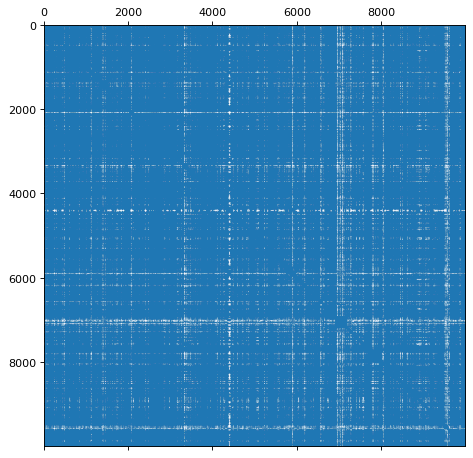

In [111]:
# Vidualize similarity between books
plt.figure(figsize=(6, 6), dpi=80)
plt.spy(book_cosine_sim, precision = 0.1, markersize = 0.04)
plt.tight_layout()
plt.show()

In [112]:
books = pd.Series(model_data['Name'])

def recommend_books_similar_to(book_name, n=5, cosine_sim_mat=book_cosine_sim):
    # get index of the imput book
    input_idx = books[books == book_name].index[0]
    # Find top n similar books with decreasing order of similarity score
    top_n_books_idx = list(pd.Series(cosine_sim_mat[input_idx]).sort_values(ascending = False).iloc[1:n+1].index)
    # [1:6] to exclude 0 (index 0 is the input movie itself)

    books_list = list(books)
    recommended_books = [books[i] for i in top_n_books_idx]

    return recommended_books

In [114]:
model_data

,Id,Name,keywords
0,2312681,the it's just lunch guide to dating in san die...,cathy_a._loe 10_finger_press dates dating da...
1,2094452,faux frère,paul_doherty 10/18 fre doherty corbette corbe...
2,2934265,un deuil dangereux,anne_perry 10/18 fre monk basil poignardée in...
3,2882410,prevention from the inside-out,jack_pransky 1st_book_library nan
4,2792583,symphonic paradox: the misadventures of a wayw...,sam_denov 1st_book_library denov orchestras ...
...,...,...,...
9993,2489508,gymboree baby play,wendy_s._masi nan
9994,2679310,the hadra,diana_rivers eng chronicles tribe hadra dian...
9995,2145700,winnie pooh tesoros para llevar (disney winnie...,arlette_de_alba nan
9996,2000878,concepts of modern art revised and enlarge (wo...,nikos_stangos art artistic expressionism es...


In [115]:
# Recommendations with series information
print("\033[1m{}\033[0m".format("Recommendation (Series Information) based on the read: The Lock and Key Library"))
display(recommend_books_similar_to("the lock and key library", 5))

Recommendation (Series Information) based on the read: The Lock and Key Library


['queste (septimus heap, #4)',
 'insider dealing and money laundering in the eu: law and regulation',
 'the procession',
 'dark metro, vol. 1',
 'd.a.: prosecutors in their own words']

In [116]:
# Recommendations with series information numbered
print("\n\033[1m{}\033[0m".format("Recommendation (Numbered Series) based on the read: The Songs of High North"))
display(recommend_books_similar_to("songs of the high north", 5))


Recommendation (Numbered Series) based on the read: The Songs of High North


["in 5 minits you'll know me: selected poems, 1985-95",
 'next: new poems',
 'the despairs',
 'later on: the monaghan bombing memorial anthology',
 'redshift']

In [1]:
print("\n\033[1m{}\033[0m".format("Recommendation (Theme: Chins) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)"))
display(recommend_books_similar_to('	oil for the lamps of china', 5))


Recommendation (Theme: Chins) based on the read: The Practice of Programming (Addison-Wesley Professional Computing Series)


NameError: ignored